In [2]:
# 얼굴인식(얼굴정보)세로*가로*3넘파이 => 1*512(임베딩데이터로 변환) => X, y를 머신러닝(SVM)

# 1. 데이터셋 다운로드 및 압축해제
https://www.kaggle.com/datasets/dansbecker/5-celebrity-faces-dataset?resource=download

In [ ]:
!unzip data/5celebrity.zip -d data/5celebrity/

# 2. 얼굴 Detect

In [ ]:
# ! pip install mtcnn

In [9]:
from mtcnn import MTCNN
import PIL
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 2.1 MTCNN을 이용해서 얼굴 형태 탐지

In [10]:
detector = MTCNN()  # 객체
image = cv2.imread('data/5celebrity/train/ben_afflek/httpcsvkmeuaeccjpg.jpg', cv2.IMREAD_ANYCOLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)
result

[{'box': [14, 30, 76, 92],
  'confidence': 0.9998857975006104,
  'keypoints': {'nose': [36, 91],
   'mouth_right': [64, 98],
   'right_eye': [51, 63],
   'left_eye': [27, 75],
   'mouth_left': [44, 109]}}]

## 2.2 탐지한 얼굴 그려보기

In [11]:
box = result[0]['box']  # 좌상부분의 x, y, width, height
x, y, w, h = box
keypoints = result[0]['keypoints']  # nose, mouth_right, right_eye, left_eye, mouth_left 좌표
cv2.rectangle(image,
              (x, y),                # 사각형 좌상 좌표
              (x+w, y+h),  # 사각형 우하 좌표
              (0, 155, 255),
              2)
cv2.circle(image,
           keypoints['nose'],  # 원의 중심점
           2,                  # 반지름
           (255, 0, 0),        # 원의 색상
           2)
cv2.circle(image, keypoints['mouth_right'], 2, (255, 0, 0), 2)
cv2.circle(image, keypoints['right_eye'], 2, (255, 0, 0), 2)
cv2.circle(image, keypoints['left_eye'], 2, (255, 0, 0), 2)
cv2.circle(image, keypoints['mouth_left'], 2, (255, 0, 0), 2)
cv2.imwrite('data/ben.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

face = image[y : y+h, x : x+w]
cv2.imwrite('data/benface.jpg', cv2.cvtColor(face, cv2.COLOR_RGB2BGR))

True

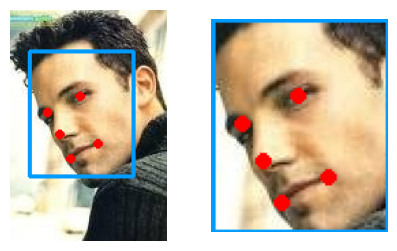

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3))
axes[0].imshow(image)
axes[0].axis('off')
axes[1].imshow(face)
axes[1].axis('off')
plt.show()

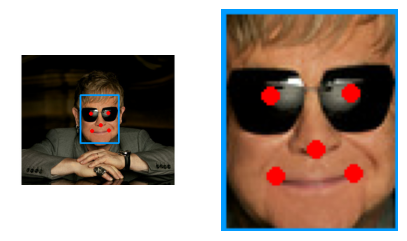

In [13]:
image = cv2.imread('data/5celebrity/train/elton_john/12.jpg', cv2.IMREAD_ANYCOLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)

box = result[0]['box']  # 좌상부분의 x, y, width, height
x, y, w, h = box
keypoints = result[0]['keypoints']  # nose, mouth_right, right_eye, left_eye, mouth_left 좌표
cv2.rectangle(image, (x, y), (x+w, y+h), (0, 155, 255), 2)
cv2.circle(image, keypoints['nose'], 2, (255, 0, 0), 2)
cv2.circle(image, keypoints['mouth_right'], 2, (255, 0, 0), 2)
cv2.circle(image, keypoints['right_eye'], 2, (255, 0, 0), 2)
cv2.circle(image, keypoints['left_eye'], 2, (255, 0, 0), 2)
cv2.circle(image, keypoints['mouth_left'], 2, (255, 0, 0), 2)
cv2.imwrite('data/ben.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

face = image[y : y+h, x : x+w]
cv2.imwrite('data/benface.jpg', cv2.cvtColor(face, cv2.COLOR_RGB2BGR))

fig, axes = plt.subplots(1, 2, figsize=(5, 3))
axes[0].imshow(image)
axes[0].axis('off')
axes[1].imshow(face)
axes[1].axis('off')
plt.show()

## 2.3 입력형식에 맞게 차원 변환

In [14]:
face.shape

(83, 66, 3)

In [15]:
face_data = np.expand_dims(face, axis=0)
# face_data = face.reshape(-1, face.shape[0], face.shape[1], face.shape[2])
face_data = face[np.newaxis, :]
face_data.shape

(1, 83, 66, 3)

# 3. Facenet을 활용하여 임베딩 데이터로 변환(face_data를)
 - face_data : 1*83*66*3
 - 임베딩 데이터 : 1*512

In [16]:
# ! pip install keras-facenet

In [17]:
from keras_facenet import FaceNet
model = FaceNet()

## 3.1 이미지 데이터를 FaceNet 임베딩 데이터로 변환

In [18]:
# face_data 얼굴 이미지이거나 얼굴 특징 데이터가 있는 이미지를 유사성을 측정할 수 있는 1*512 배열로 변환
face_embedding = model.embeddings(face_data)
face_embedding.shape

1/1 [==============================] - 5s 5s/step


(1, 512)

In [19]:
face_embedding[0, :10]

array([-0.00535405,  0.03481745,  0.06170095,  0.1202163 ,  0.00196334,
        0.04806111, -0.07896573, -0.04746439, -0.05991841, -0.02178189],
      dtype=float32)

# 4. 분류모델을 만들기 위한 데이터셋 생성
 - X_train(n*512), y_train(n) * n은 train 폴더 안의 사진갯수
 - X_test(m*512), y_test(m)   * m은 test 폴더 안의 사진갯수

## 4.1 y_train(사람이름)과 X_train에 사용될 이미지 경로(x_train_path)
 - y_test(사람이름)과 X_test에 사용될 이미지 경로(x_test_path)

In [20]:
import os
train_path = 'data/5celebrity/train'
test_path  = 'data/5celebrity/val'

In [21]:
# list(os.walk(train_path))
for x in os.walk(train_path):
    print(x)
    print('------------------------------------------------------------------')

('data/5celebrity/train', ['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling'], [])
------------------------------------------------------------------
('data/5celebrity/train\\ben_afflek', [], ['httpcsvkmeuaeccjpg.jpg', 'httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg', 'httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg', 'httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg', 'httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg', 'httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg', 'httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg', 'httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg', 'httptrwebimgacstanetcxbdddmediasnmediajpg.jpg', 'httpwwwaceshowbizcomimagesphotobenaffleckjpg.jpg', 'httpwwwallposterscomimagesPostersPFjpg.jpg', 'httpwwwfilmscoopitcgibinattoriBENAFFLECKBENAFFLECKjpg.jpg', 'httpwwwhillsindcomstorebenjpg.jpg', 'httpwwwrumen

In [22]:
def get_path(path):
    x_path = []
    y = []
    for x in os.walk(path):
        if len(x[2]) == 0:
            # print(x, '에는 파일이 없습니다.')
            continue
        name = os.path.basename(x[0])
        print(name, '사진', len(x[2]), '장 parsing 중')
        # print(x[0])  # 폴더 경로
        # print(x[1])  # 하위폴더
        # print(x[2])  # 파일
        for file_name in x[2]:
            # image_full_path = x[0].replace('\\', '/') + '/' + file_name
            image_full_path = path + '/' + name + '/' + file_name
            x_path.append(image_full_path)
            y.append(name)
    # print(len(y))
    # print(len(x_path))
#     for name, path in zip(y, x_path):
#         print(name, path)
    return x_path, y

In [23]:
# get_path(train_path)
x_train_path, y_train = get_path(train_path)
x_test_path, y_test = get_path(test_path)

ben_afflek 사진 14 장 parsing 중
elton_john 사진 16 장 parsing 중
jerry_seinfeld 사진 21 장 parsing 중
madonna 사진 19 장 parsing 중
mindy_kaling 사진 22 장 parsing 중
ben_afflek 사진 5 장 parsing 중
elton_john 사진 5 장 parsing 중
jerry_seinfeld 사진 5 장 parsing 중
madonna 사진 5 장 parsing 중
mindy_kaling 사진 5 장 parsing 중


In [24]:
len(x_train_path), len(y_train), len(x_test_path), len(y_test)  # 넘파이배열이 아닌 list

(92, 92, 25, 25)

In [25]:
for y, x in zip(y_train[::10], x_train_path[::10]):
    print(y, '-', x)

ben_afflek - data/5celebrity/train/ben_afflek/httpcsvkmeuaeccjpg.jpg
ben_afflek - data/5celebrity/train/ben_afflek/httpwwwallposterscomimagesPostersPFjpg.jpg
elton_john - data/5celebrity/train/elton_john/14.jpg
jerry_seinfeld - data/5celebrity/train/jerry_seinfeld/httpgraphicsnytimescomimagessectionmoviesfilmographyWireImagejpg.jpg
jerry_seinfeld - data/5celebrity/train/jerry_seinfeld/httpstatictherichestimagescomcdncwpcontentuploadsJerrySeinfeldjpg.jpg
jerry_seinfeld - data/5celebrity/train/jerry_seinfeld/httpwwwwatchidcomsitesdefaultfilesuploadsightingBreitlingwatchJerrySeinfeldjpg.jpg
madonna - data/5celebrity/train/madonna/httpssmediacacheakpinimgcomxffabffabbbcfbceaedjpg.jpg
mindy_kaling - data/5celebrity/train/mindy_kaling/httpgonetworthcomwpcontentuploadsthumbsjpg.jpg
mindy_kaling - data/5celebrity/train/mindy_kaling/httpssmediacacheakpinimgcomxbbfcbdedfbfdbjpg.jpg
mindy_kaling - data/5celebrity/train/mindy_kaling/httpwwwpictureszimbiocomfpMindyKalingfBgaONVFDFmjpg.jpg


In [26]:
for y, x in zip(y_test[::10], x_test_path[::10]):
    print(y, '-', x)

ben_afflek - data/5celebrity/val/ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg
jerry_seinfeld - data/5celebrity/val/jerry_seinfeld/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIwNjANjMMDINzIxNjcjpg.jpg
mindy_kaling - data/5celebrity/val/mindy_kaling/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIOTcwODQNTUzNjQMzcjpg.jpg


## 4.2 임베딩함수를 통해 전체 학습 이미지를 임베딩 처리한 후 train_X 리스트에 저장

In [27]:
# face_embedding[0] : 92행(장) 512열의 얼굴 유사성

In [28]:
def make_embedding(path):
    # from mtcnn import MTCNN
    # from keras_facenet import FaceNet
    'path의 이미지 읽어오기 -> 얼굴정보만 추출 -> facenet을 통해 임베딩 데이터로 전환'
    # print(path)
    
    image = cv2.imread(path, cv2.IMREAD_ANYCOLOR)   # BGR포맷으로 읽어오기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB포맷의 넘파이배열로 변환
    # detector = MTCNN()                              # 얼굴정보만 추출하기 위한 객체
    result = detector.detect_faces(image)           # detect_faces(넘파이배열)
    
    if not result:  # result == False(참)
        print(path, '의 파일에서는 얼굴을 인지하지 못하였습니다.')
    # print(result)
    
    x, y, w, h = result[0]['box']   # 얼굴정보
    # print(x, y, w, h)
    face = image[y : y+h, x : x+w]  # 얼굴정보만 추출(3차원)
    
    # face 데이터 축 추가(임베딩처리를 위함)
    input_data = np.expand_dims(face, axis=0)
    # print(face.shape, input_data.shape)
    
    # input_data를 임베딩 데이터로 전환
    # model = FaceNet()
    face_embedding = model.embeddings(input_data)  # 2차원(1, 512)
    return face_embedding

In [29]:
X_train_list = []
for image_full_path in x_train_path:
    face_embedding = make_embedding(image_full_path)
    # print(face_embedding[0])
    X_train_list.append(face_embedding[0])
len(X_train_list)

1/1 [==============================] - 0s 31ms/step


92

In [39]:
X_test_list = []

for image_full_path in x_test_path:
    face_embedding = make_embedding(image_full_path)
    X_test_list.append(face_embedding[0])

1/1 [==============================] - 0s 33ms/step


In [40]:
len(X_train_list), len(y_train), len(X_test_list), len(y_test)

(92, 92, 25, 25)

In [41]:
X_train = np.array(X_train_list)  # 1차원 -> 2차원
X_test  = np.array(X_test_list)   # 1차원 -> 2차원
X_train.shape, X_test.shape

((92, 512), (25, 512))

# 5. SVM(Support Vector Machine) 알고리즘을 이용하여 모델 생성

In [42]:
# svm : 분류분석기, 회귀분석기
from sklearn import preprocessing, svm
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

classifier = svm.SVC(kernel='linear', probability=True)  # 확률값 출력
classifier.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [43]:
y_hat = classifier.predict(X_test)  # X_test의 예측값
accuracy = accuracy_score(y_test,   # 실제값
                          y_hat)    # 예측값
print(accuracy*100, '%')

100.0 %


In [44]:
confusion_matrix(y_test, y_hat)  # 혼돈행렬

array([[5, 0, 0, 0, 0],
       [0, 5, 0, 0, 0],
       [0, 0, 5, 0, 0],
       [0, 0, 0, 5, 0],
       [0, 0, 0, 0, 5]], dtype=int64)

In [45]:
pd.crosstab(y_test, y_hat)

col_0,ben_afflek,elton_john,jerry_seinfeld,madonna,mindy_kaling
row_0,,,,,
ben_afflek,5,0,0,0,0
elton_john,0,5,0,0,0
jerry_seinfeld,0,0,5,0,0
madonna,0,0,0,5,0
mindy_kaling,0,0,0,0,5


# 6. 생성된 모델 사용하기(예측하기)

In [46]:
image_path = 'data/test_elton.jpg'
face_embedding = make_embedding(image_path)
face_embedding.shape

1/1 [==============================] - 0s 31ms/step


(1, 512)

In [47]:
classifier.predict(face_embedding)

array(['elton_john'], dtype='<U14')

In [48]:
image_path = 'data/test_madonna.jpg'
face_embedding = make_embedding(image_path)
print(classifier.predict_proba(face_embedding))
print(classifier.predict(face_embedding))

1/1 [==============================] - 0s 33ms/step
[[0.05697852 0.04773335 0.04564123 0.70431191 0.14533499]]
['madonna']


# 7. 모델저장

In [49]:
# SVC 모델은 h5파일로 저장되지 않음
import joblib
joblib.dump(classifier, 'model/face_svc.pkl')

['model/face_svc.pkl']

# 8. 모델 불러오기

In [50]:
loaded_model = joblib.load('model/face_svc.pkl')

1/1 [==============================] - 0s 33ms/step
['madonna']
[[0.05697852 0.04773335 0.04564123 0.70431191 0.14533499]]


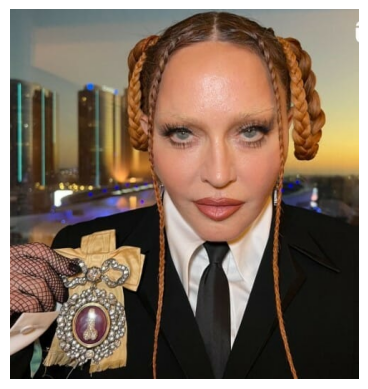

In [52]:
image_path = 'data/test_madonna.jpg'
face_embedding = make_embedding(image_path)
print(loaded_model.predict(face_embedding))
print(loaded_model.predict_proba(face_embedding))
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

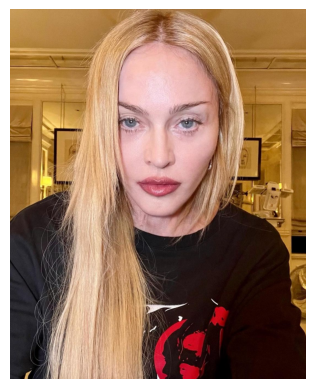

1/1 [==============================] - 0s 34ms/step
[[0.03014059 0.04889274 0.03191917 0.85915773 0.02988977]]
madonna


In [68]:
import requests
image_path = 'https://img.vogue.co.kr/vogue/2023/07/style_64accdeee21cd.jpeg'
response = requests.get(image_path)
save_path = 'data/test.jpg'
with open(save_path, 'wb') as imageFile:
    imageFile.write(response.content)
image = cv2.imread(save_path, cv2.IMREAD_ANYCOLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()
face_embedding = make_embedding(save_path)
result = loaded_model.predict_proba(face_embedding)
print(result)
names = ['ben_afflek','elton_john','jerry_seinfeld','madonna','mindy_kaling']
print(names[result.argmax(axis=1)[0]])